REPLICATION OF FIRST CHAPTER SIMULATIONS

In [2]:
import numpy as np
from numpy import random as rnd
import pandas as pd
import math
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import scipy
from scipy.stats.distributions import chi2
import statistics
from statistics import mean

In [ ]:
def fun_min_eig(w,  z, n):
    sigw = (w.T @ w) / n
    sigw12 = scipy.linalg.sqrtm(sigw)
    wpzw = (w.T @ z) @ (np.linalg.lstsq(z, w, rcond = None)[0])
    eig_mat = np.linalg.inv(sigw12) @ wpzw @ np.linalg.inv(sigw12) / n
    return np.linalg.eigvals(eig_mat).min()

def fun_score(z, xhat, uhat, degs):
    z2 = z[:,-degs:]
    mxz = z2 - xhat @ (np.linalg.lstsq(xhat, z2, rcond = None)[0])
    variance = mxz.T @(np.diagflat(uhat * uhat)) @ mxz
    return uhat.T @ mxz @ (np.linalg.inv(variance)) @ mxz.T @ uhat

Exp_1_kz_3_rho_20.png
Exp_1_kz_3_rho_50.png
Exp_1_kz_3_rho_95.png
Exp_1_kz_7_rho_20.png
Exp_1_kz_7_rho_50.png
Exp_1_kz_7_rho_95.png
Exp_2_kz_3_rho_20.png
Exp_2_kz_3_rho_50.png
Exp_2_kz_3_rho_95.png
Exp_2_kz_7_rho_20.png
Exp_2_kz_7_rho_50.png
Exp_2_kz_7_rho_95.png


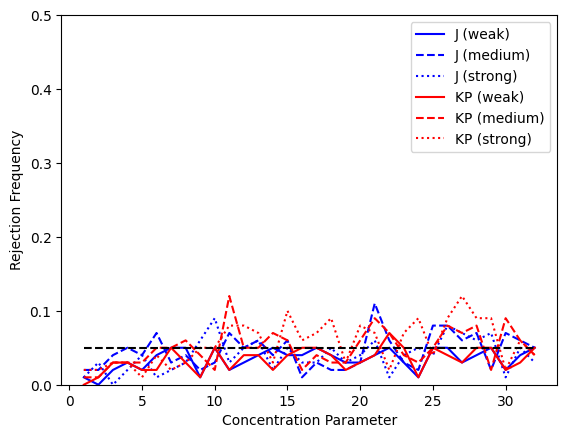

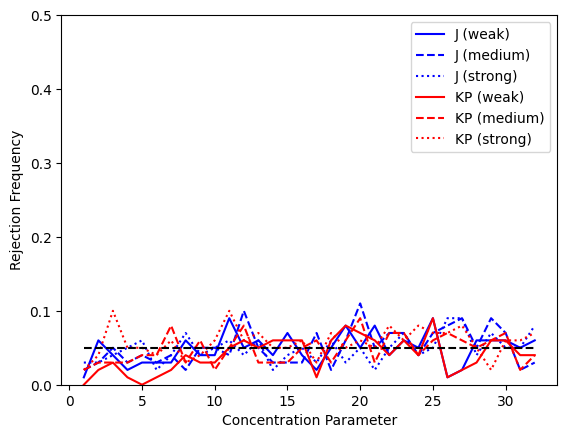

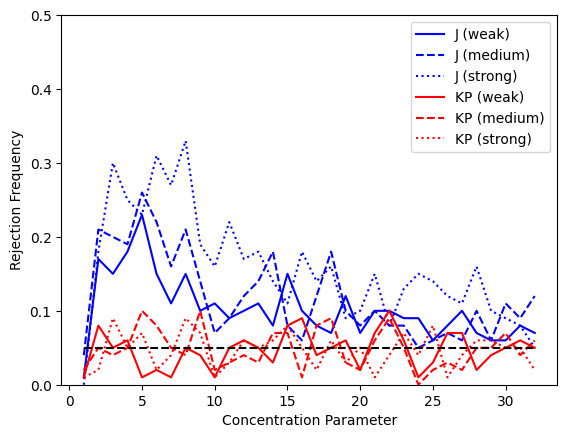

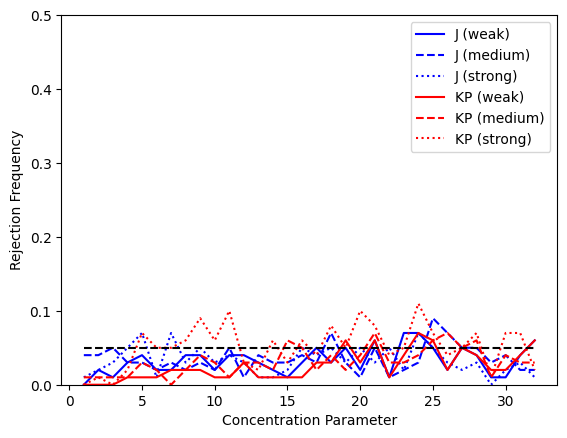

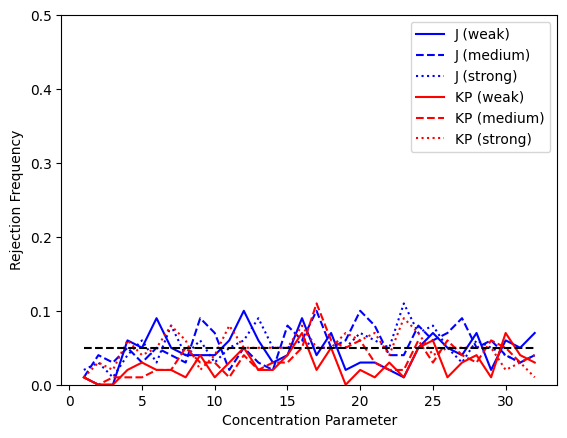

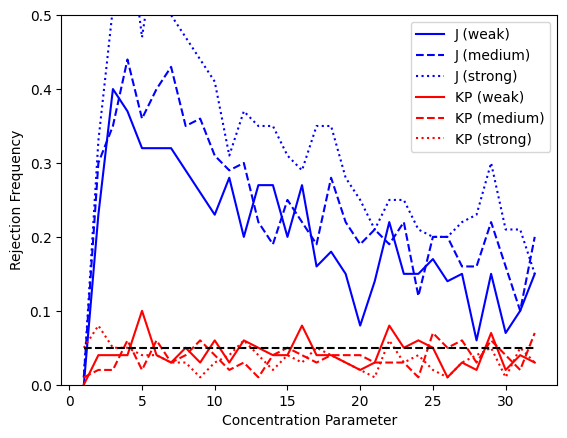

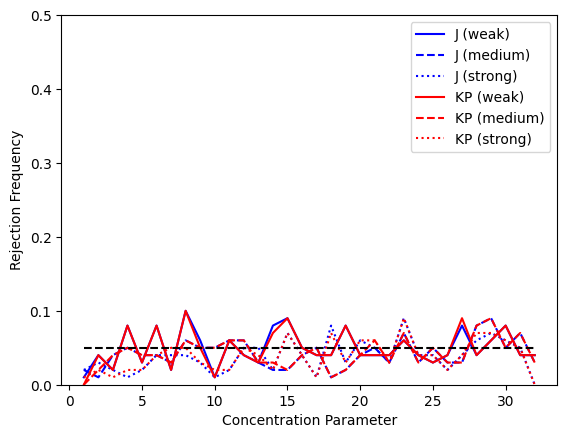

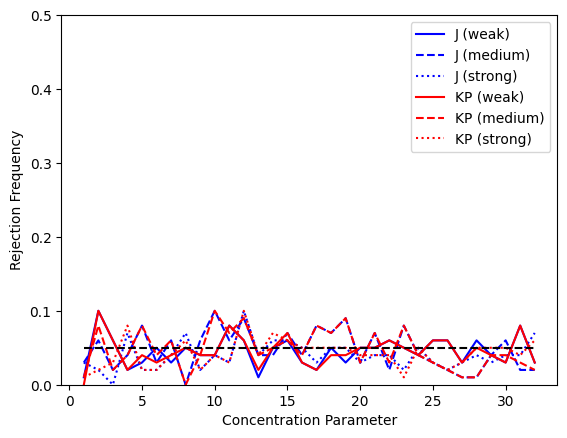

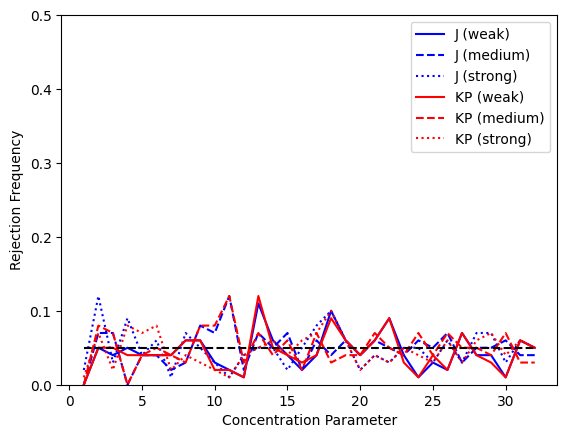

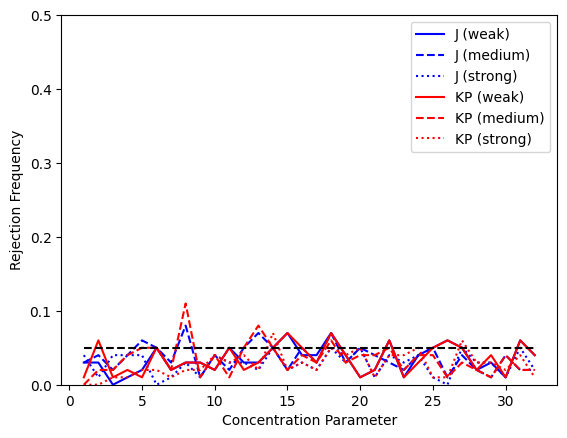

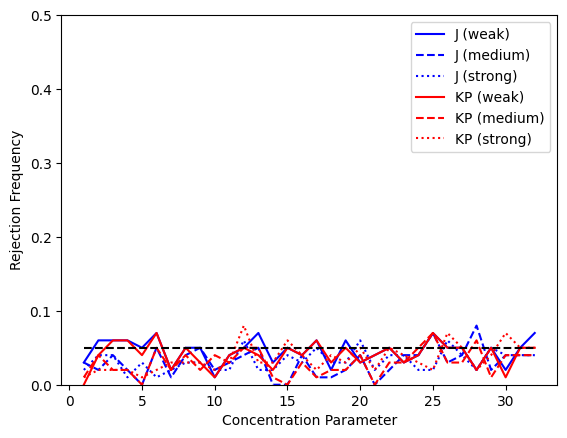

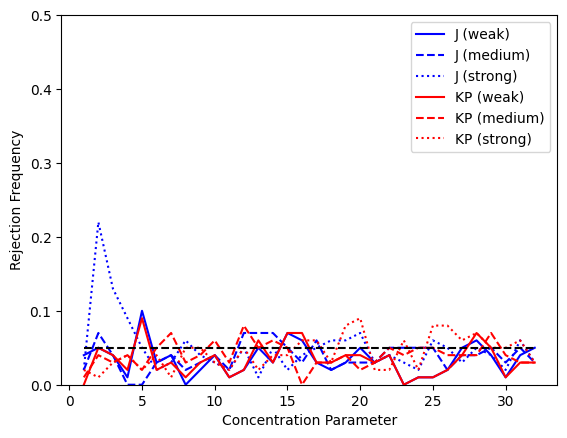

In [16]:
# THIS CODE RECREATES THE MONTE CARLO SECTION OF CHAPTER 1

# Set to j for Experiment j
Experiment_vals = [1,2] # Change to singleton to just run a particular experiment

# Parameter values for simulation
num_sims = 10000
n = 200

mu2_max = 32
rho_vals = [0.2, 0.5, 0.95]
kz_vals = [3, 7]

for Experiment in Experiment_vals:

    if Experiment == 1:

        alpha_vals = [0.5, 1, 2]
        fac_vals = [0.8, 1, 3]

    else:

        alpha_vals = [0.05, 0.1, 0.2]
        fac_vals = [1.014, 1.056, 1.246]

    kx = 1
    beta = 1

    mu_uv = [0,0]

    for kz in kz_vals:

        degs = kz - kx - 1
        mu_z = [0] * kz
        sigma_z = np.identity(kz)

        for rho in rho_vals:

            sigma_uv = [[1, rho] , [rho, 1]]

            hansen_rej_freq_weak_mu2 = []
            kp_rej_freq_weak_mu2 = []
            hansen_rej_freq_medium_mu2 = []
            kp_rej_freq_medium_mu2 = []
            hansen_rej_freq_strong_mu2 = []
            kp_rej_freq_strong_mu2 = []

            for j in range(mu2_max):

                mu2 = j

                hansen_rej_weak = []
                kp_rej_weak = []
                hansen_rej_medium = []
                kp_rej_medium = []
                hansen_rej_strong = []
                kp_rej_strong = []

                for alphaj in range(3):

                    alpha = alpha_vals[alphaj]
                    fac = fac_vals[alphaj]
                    pp = np.sqrt((fac * mu2) / (n * kz))
                    pp_vec = pp * np.ones((kz, 1))

                    for i in range(num_sims):

                        z = rnd.multivariate_normal(mu_z, sigma_z, n)
                        eps = rnd.multivariate_normal(mu_uv, sigma_uv, n)

                        # HETEROSKEDASTICITY FACTOR 
                        
                        if Experiment == 1:
                            
                            het_factor = (abs(z[:, 0])) ** alpha

                        else:

                            alpha_z_vec = [alpha] * kz
                            het_factor = z @ alpha_z_vec  

                        eps1 = het_factor * eps[:, 0]
                        eps2 = het_factor * eps[:, 1]

                        u = eps1.reshape(-1, 1)
                        v = eps2.reshape(-1, 1)

                        X = z @ pp_vec + v
                        y = X * beta + u

                        # ESTIMATOR VALUES
                    
                        izz = np.linalg.inv(z.T @ z)
                        Pi2sls = np.linalg.lstsq(z, X, rcond = None)[0]
                        X2sls = z @ Pi2sls
                        b2sls = np.linalg.lstsq(X2sls, y, rcond = None)[0]
                        u2sls = y - X * b2sls

                        w = np.concatenate((y, X), axis = 1)

                        min_eig = fun_min_eig(w, z, n)
                        bliml = ((X2sls.T @ y - min_eig * (X.T @ y))) / ((X2sls.T @ X - min_eig * (X.T @ X)))
                        uliml = y - X * bliml
                        Muliml = np.identity(n) - uliml @ (np.linalg.inv(uliml.T @ uliml)) @ uliml.T
                        Piliml = (np.linalg.inv(z.T @ Muliml @ z)) @ (z.T @ Muliml @ X)
                        Xliml = z @ Piliml

                        # TEST STATISTICS

                        hansen = fun_score(z, X2sls, u2sls, degs)
                        kp = fun_score(z, Xliml, uliml, degs)
                        hansen_reject = (hansen > chi2.ppf(0.95, df = degs))
                        kp_reject = (kp > chi2.ppf(0.95, df = degs))

                        crit_val = chi2.ppf(0.95, df = degs)

                        if alphaj == 0:

                            if hansen < crit_val:

                                hansen_rej_weak.append(0)
                                
                            else:

                                hansen_rej_weak.append(1)
                                
                            if kp < crit_val:

                                kp_rej_weak.append(0)

                            else:

                                kp_rej_weak.append(1)

                        elif alphaj == 1:

                            if hansen < crit_val:

                                hansen_rej_medium.append(0)

                            else:

                                hansen_rej_medium.append(1)
                                
                            if kp < crit_val:

                                kp_rej_medium.append(0)

                            else:

                                kp_rej_medium.append(1)

                        elif alphaj == 2:

                            if hansen < crit_val:

                                hansen_rej_strong.append(0)

                            else:

                                hansen_rej_strong.append(1)
                                
                            if kp < crit_val:

                                kp_rej_strong.append(0)

                            else:

                                kp_rej_strong.append(1)

                        else:

                            pass

                    if alphaj == 0:

                        hansen_rej_freq_weak_mu2.append(statistics.mean(hansen_rej_weak))
                        kp_rej_freq_weak_mu2.append(statistics.mean(kp_rej_weak))

                    elif alphaj == 1:

                        hansen_rej_freq_medium_mu2.append(statistics.mean(hansen_rej_medium))
                        kp_rej_freq_medium_mu2.append(statistics.mean(kp_rej_medium))

                    elif alphaj == 2:

                        hansen_rej_freq_strong_mu2.append(statistics.mean(hansen_rej_strong))
                        kp_rej_freq_strong_mu2.append(statistics.mean(kp_rej_strong))

                    else:

                        pass

            vals = pd.DataFrame(data=[hansen_rej_freq_weak_mu2, kp_rej_freq_weak_mu2, hansen_rej_freq_medium_mu2, kp_rej_freq_medium_mu2, hansen_rej_freq_strong_mu2, kp_rej_freq_strong_mu2, np.linspace(1, 32,32), np.linspace(0.05,0.05,32)]).T
            vals.columns = ['hansen_weak', 'kp_weak', 'hansen_medium', 'kp_medium', 'hansen_strong', 'kp_strong', 'mu2', 'hline']
            
            file = ['Exp', Experiment, 'kz', kz, 'rho', int(rho * 100)]
            figname = ['Exp', Experiment, 'kz', kz, 'rho', int(rho * 100)]
            figname = f'{file[0]}_{file[1]}_{file[2]}_{file[3]}_{file[4]}_{file[5]}'
        
            plt.figure() # without this, the figures write on top of each other, that's all this line
            figname = sns.lineplot(data = vals, x = 'mu2', y = 'hansen_weak', color = 'blue', label = 'J (weak)')
            sns.lineplot(data = vals, x = 'mu2', y = 'hansen_medium', color = 'blue', linestyle = '--', label = 'J (medium)')
            sns.lineplot(data = vals, x = 'mu2', y = 'hansen_strong', color = 'blue', linestyle = ':', label = 'J (strong)')
            sns.lineplot(data = vals, x = 'mu2', y = 'kp_weak', color = 'red', label = 'KP (weak)')
            sns.lineplot(data = vals, x = 'mu2', y = 'kp_medium', color = 'red', linestyle = '--', label = 'KP (medium)')
            sns.lineplot(data = vals, x = 'mu2', y = 'kp_strong', color = 'red', linestyle = ':', label = 'KP (strong)')
            sns.lineplot(data = vals, x = 'mu2', y = 'hline', linestyle = '--', color = 'black')
            
            figname.legend()
            figname.set(xlabel = 'Concentration Parameter', ylabel = 'Rejection Frequency')
            figname.set(ylim = (0, 0.5))

            filename = f'{file[0]}_{file[1]}_{file[2]}_{file[3]}_{file[4]}_{file[5]}.png'
            print(filename)

            figure = figname.get_figure()
            figure.savefig(filename)
            figure.clear